## PH4044 Tutorial 3

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate

### Question 1

#### NOTES TO MYSELF
- Question seems to allow use to vary $\eta_f$. The challenge is going to be comming up with a suitable scale. 
- $E$ / $eta$ we can intentionally set to a specific value I think and vary $\eta_f$ around it.

In [8]:
# Define all constants
T = 23 + 273.15 # K
m_0 = 9.109E-31 # kg
k_B = 1.381E-23 # J/K
hbar = 1.055E-34

In [11]:
# Define the effective concentration
def N_c(m_e, T):
    return 2*((m_e*k_B*T)/(2*np.pi*hbar**2))**(3/2)

# Define the Fermi Integral
def F_half(eta_f):
    F_half_values = []
    for eta_value in eta_f:
        integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))
        F_half_values.append(integrate.quad(integrand, 0, np.inf)[0])
    return np.array(F_half_values)
    

# Define the n using the Fermi-dirac distribution 
def n_f(eta_f, m_e, T):
    return (2/np.sqrt(np.pi))*N_c(m_e, T)*F_half(eta_f)

# Define n using the Boltzmann Approximation
def n_b(eta_f, m_e, T):
    return N_c(m_e, T)*np.exp(eta_f)

In [14]:
eta_f = np.arange(0, 10, 0.1)
n_f(eta_f, m_0, T)
n_b(eta_f, m_0, T)

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_971/3274783136.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


array([2.45904791e+25, 2.71766824e+25, 3.00348790e+25, 3.31936748e+25,
       3.66846841e+25, 4.05428460e+25, 4.48067743e+25, 4.95191439e+25,
       5.47271177e+25, 6.04828190e+25, 6.68438526e+25, 7.38738819e+25,
       8.16432659e+25, 9.02297631e+25, 9.97193101e+25, 1.10206882e+26,
       1.21797440e+26, 1.34606989e+26, 1.48763730e+26, 1.64409348e+26,
       1.81700430e+26, 2.00810031e+26, 2.21929406e+26, 2.45269925e+26,
       2.71065189e+26, 2.99573363e+26, 3.31079769e+26, 3.65899732e+26,
       4.04381743e+26, 4.46910942e+26, 4.93912976e+26, 5.45858258e+26,
       6.03266672e+26, 6.66712781e+26, 7.36831577e+26, 8.14324830e+26,
       8.99968120e+26, 9.94618593e+26, 1.09922354e+27, 1.21482989e+27,
       1.34259467e+27, 1.48379658e+27, 1.63984883e+27, 1.81231324e+27,
       2.00291589e+27, 2.21356439e+27, 2.44636699e+27, 2.70365365e+27,
       2.98799939e+27, 3.30225002e+27, 3.64955069e+27, 4.03337729e+27,
       4.45757128e+27, 4.92637814e+27, 5.44448986e+27, 6.01709185e+27,
      

### NOTES TO MYSELF
- The reason I've got these crazy values is because I'm totally ignoring the scale of $E_f$, $E_c$ and $kT$ when generating my $\eta_f$ values. 
- I need to generate values that are on the correct order of magnitude. 
- I would also generally expect $\eta_f < 0$ if the fermi energy is lower than the conduction band energy (which it should be in almost every case bar maybe doping). 

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_971/3274783136.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


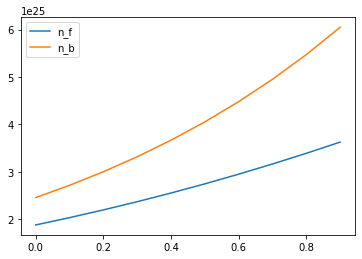

In [17]:
# Plot n_b against n_f 
eta_f = np.arange(0, 1, 0.1)

fig = plt.figure()
plt.plot(eta_f, n_f(eta_f, m_0, T), label='n_f')
plt.plot(eta_f, n_b(eta_f, m_0, T), label='n_b')
plt.legend()
